## Audience Imact on Game

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

In [2]:
# The data files for each league
epl_att_data = "../final-resources/EPL/EPL_scores_attendances.csv"
bun_att_data = "../final-resources/BUN/BUN_scores_attendances.csv"
lig_att_data = "../final-resources/LIG/LIG_scores_attendances.csv"
ser_att_data = "../final-resources/SER/SER_scores_attendances.csv"
images_path = "../images/Audience_impact/"

### Setting and Functions for charts


In [7]:
# The following columns will be selected from the dataset
cols = ["Date",
    "HomeTeam",
    "HomeTeam ID", 
    "HomeScore",
    "AwayTeam",
    "AwayTeam ID",
    "AwayScore", 
    "Result",
    "Attendance"]


# Data cleaning (fillna, types) and print summary numbers
def Summary(df, league):

    ndf = df.copy()
    s = df["Attendance"]

    if s.dtype == 'object':
        ndf["Attendance"] = s.str.replace(',', '').astype(float)
    ndf = ndf.fillna(0)
    
    # Filter all the rows for which there is no attendance and the match date is before Covid
    # -- Attendance data is missing
    Covid_date = "2020-04-01"
    ddf = ndf.loc[ (ndf["Attendance"]==0) & (ndf["Date"]<Covid_date) ]
    ndf.drop(ddf.index, inplace=True)
    
    # The total number of matches of the 'league' in 2019-20
    total = len(ndf['Date'])

    # The number of matches after COVID-19
    
    after = len(ndf.loc[ndf["Date"] > Covid_date])

    print(f"The number of matches of {league} teams until {ndf['Date'].at[total -1]} is {total}")
    print(f"The number of matches of {league} teams after COVID-19 is {after}")
    return ndf


# Plot a horizontal bar chart of average attendance&score for each team 
def Home_Away_Avg_bar_chart(df, league):
    
    # The colors for league: ['Home', 'Away', edgecolor]
    L_colors = {
        "EPL"   : ["crimson","mistyrose","midnightblue"],
        "BUN"   : ["red","navajowhite","black"],
        "SER"   : ["royalblue","powderblue","black"],
        "LIG"   : ["orangered","aquamarine","black"]}

    # font size for the charts
    font_s = {
        "t" : 20,  #title
        "s" : 18,  #sub title
        'l' : 14 } #label 
    
    # Average of data
    avg_df = df.groupby("HomeTeam").mean()
    avg_df = avg_df.sort_values(by="HomeScore")

    # home scores and attendances
    home_score = avg_df["HomeScore"]
    home_att = avg_df["Attendance"]
    teams = avg_df.index

    # Average of away scores, away attendances
    gp_away = df.groupby("AwayTeam")
    away_score = []
    away_att = []
    for team in teams:
        team_away_score = gp_away.get_group(team)["AwayScore"].mean()
        team_away_att = gp_away.get_group(team)["Attendance"].mean()
        away_score.append(team_away_score)
        away_att.append(team_away_att)

    # Bar plot parameters
    bar_h = 2
    alpha = 0.7
    font_s = {
        "t" : 40,  #title
        "s" : 28,  #sub title
        'l' : 18 } #label
    edge_c = L_colors[league][2]
    
    # figure with two subplots
    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(30,12), gridspec_kw={'width_ratios': [1, 2]})
    fig.suptitle(league+": Average Scores and Attendances", fontsize=font_s["t"])
    yval = np.arange(len(teams))*6
    
    # ax1 -- scores (horizontal bar from right side)
    ax1.set_title("Home Scores vs. Away Scores", fontsize=font_s["s"])
    x_lim = 0.5 + max(max(home_score), max(away_score))
    ax1.barh(yval-bar_h/2,
             width = home_score,
             left = [x_lim-x for x in home_score], 
             color = L_colors[league][0],
             edgecolor = edge_c,
             alpha = alpha,
             height = bar_h, 
             label = "Home")
    ax1.barh(yval+bar_h/2,
             width = away_score, 
             left = [x_lim-x for x in away_score], 
             color = L_colors[league][1],
             edgecolor = edge_c,
             alpha = alpha,
             height = bar_h, 
             label ="Away")

    ax1.set_xlim(0,x_lim)
    ax1.set_ylim(-4, max(yval)+4)
    ax1.set_xlabel("Avg. Scores", fontsize=font_s["l"])
    ax1.set_yticks([])
    ax1.legend()
                             
    # ax2 -- attendances (horizontal bar from left side)    
    ax2.set_title("Home Attendances vs. Away Attendances", fontsize=font_s["s"])
    ax2.barh(yval-bar_h/2, 
             width = home_att, 
             color = L_colors[league][0],
             edgecolor = edge_c,
             alpha = alpha,
             height = bar_h, 
             label = "Home")
    ax2.barh(yval+bar_h/2, 
             width = away_att, 
             color = L_colors[league][1], 
             edgecolor = edge_c,
             alpha = alpha,
             height = bar_h, 
             label ="Away")

    ax2.set_xlim(0,max(home_att)+1000)
    ax2.set_xlabel("Avg. Attendance", fontsize=font_s["l"])
    ax2.set_ylim(-4, max(yval)+4)
    ax2.set_yticks(yval)
    ax2.set_yticklabels(teams, fontsize=font_s["l"])
    ax2.yaxis.set_label_position("right")
    ax2.legend(fontsize=font_s["l"])
    fig.savefig(f"{images_path}{league}_bar_avg_scores_att.png", bbox_inches='tight')    
    plt.show()
    plt.close(fig)

    
# Create a function to create Linear Regression plots
def subplot_linregression(ax, xval, yval, color, p):
    
    (mm,cc,rr,pp,ss) = linregress(xval,yval)

    line_eq = "y = " + str(round(mm,2)) + " x + " + str(round(cc,2))
    est_yval = mm*xval + cc

    position = (1,max(yval)-1) if p=="H" else (1,max(yval)-2)

    ax.plot(xval, est_yval, color=color)
    ax.annotate(line_eq, position, color=color, size=12)

    return rr    
    
# Attendances vs. score
# For every match, the total scores (yval) vs. number of audience (xval)
def Att_Score_scatter(df, league):

    # The colors for league: ['Home', 'Away', 'Draw']    
    L_colors = {
        "EPL" : ["crimson","midnightblue","grey"],
        "BUN" : ["red","goldenrod","gray"],
        "SER" : ["mediumblue","deepskyblue","grey"],
        "LIG" : ["orangered","limegreen","grey"],
        "ALL" : ["darkslateblue","goldenrod","silver"],
        "Popular" : ["crimson","darkblue","silver"],
        "TOP" : ["crimson","darkblue","silver"]}

    # font size for the charts
    font_s = {
        "t" : 20,  #title
        "s" : 18,  #sub title
        'l' : 14 } #label
    
    # figure with three subplots on one axes
    fig, ax = plt.subplots(figsize=(10,5))
    ax.set_title(f"{league}: Scores vs. Attendances", fontsize=font_s["t"])
    
    # Scatter plot parameters
    wins = ["H", "A", "D"]
    win_label = {"H" : "Hometeam wins",
                 "A" : "Awayteam wins", 
                 "D" : "Draw"}
    win_col = { key:val for key,val in zip(wins, L_colors[league]) }
    win_alpha = {"H" : 1,
                 "A" : 0.7, 
                 "D" : 0.6}
    win_marker = {"H" : "o", # "circle", 
                  "A" : "v", # "triangle_down", 
                  "D" : "x"} # "x"
    
    # plot according to the wins = H / A / D
    for win in wins:
        
        # Collect the rows for the 'win'
        win_df = df.loc[df["Result"]==win]

        # xvalue is the attendace of each match
        xval = win_df["Attendance"]
            
        # yvalue is the sum of homescore and awayscore for each match
        yval = win_df["HomeScore"].add(win_df["AwayScore"])

        # scatter plot
        ax.scatter(xval, yval, 
                   c = [win_col[win]]*len(xval), 
                   alpha = win_alpha[win],
                   marker = win_marker[win],
                   label = win_label[win])

        # linear regression
        if league == "ALL" and win != "D":
            rr=subplot_linregression(ax, xval, yval, win_col[win], win)
            print(f"The r-sqared value of {win_label[win]} is {rr**2}")
            
    ax.set_xlabel("Attendance of a match", fontsize=font_s["l"])
    ax.set_ylabel("Total score of a match", fontsize=font_s["l"])
    ax.legend()
    plt.show()
    fig.savefig(f"{images_path}{league}_scatter_scores_att.png", bbox_inches='tight')
    plt.close(fig)

### Home score vs. Away score

* EPL (England Premier League)

In [8]:
# Load EPL data and fill na as 0
epl_all_data_df = pd.read_csv(epl_att_data)
epl_df = Summary(epl_all_data_df[cols], "EPL")
epl_df.describe()

The number of matches of EPL teams until 2020-07-11 is 342
The number of matches of EPL teams after COVID-19 is 62


,HomeScore,AwayScore,Attendance
count,342.000000,342.000000,342.000000
mean,1.529240,1.213450,32266.122807
std,1.245764,1.212615,21108.865179
min,0.000000,0.000000,0.000000
25%,1.000000,0.000000,20077.750000
50%,1.000000,1.000000,31299.500000
75%,2.000000,2.000000,52197.500000
max,8.000000,9.000000,73737.000000


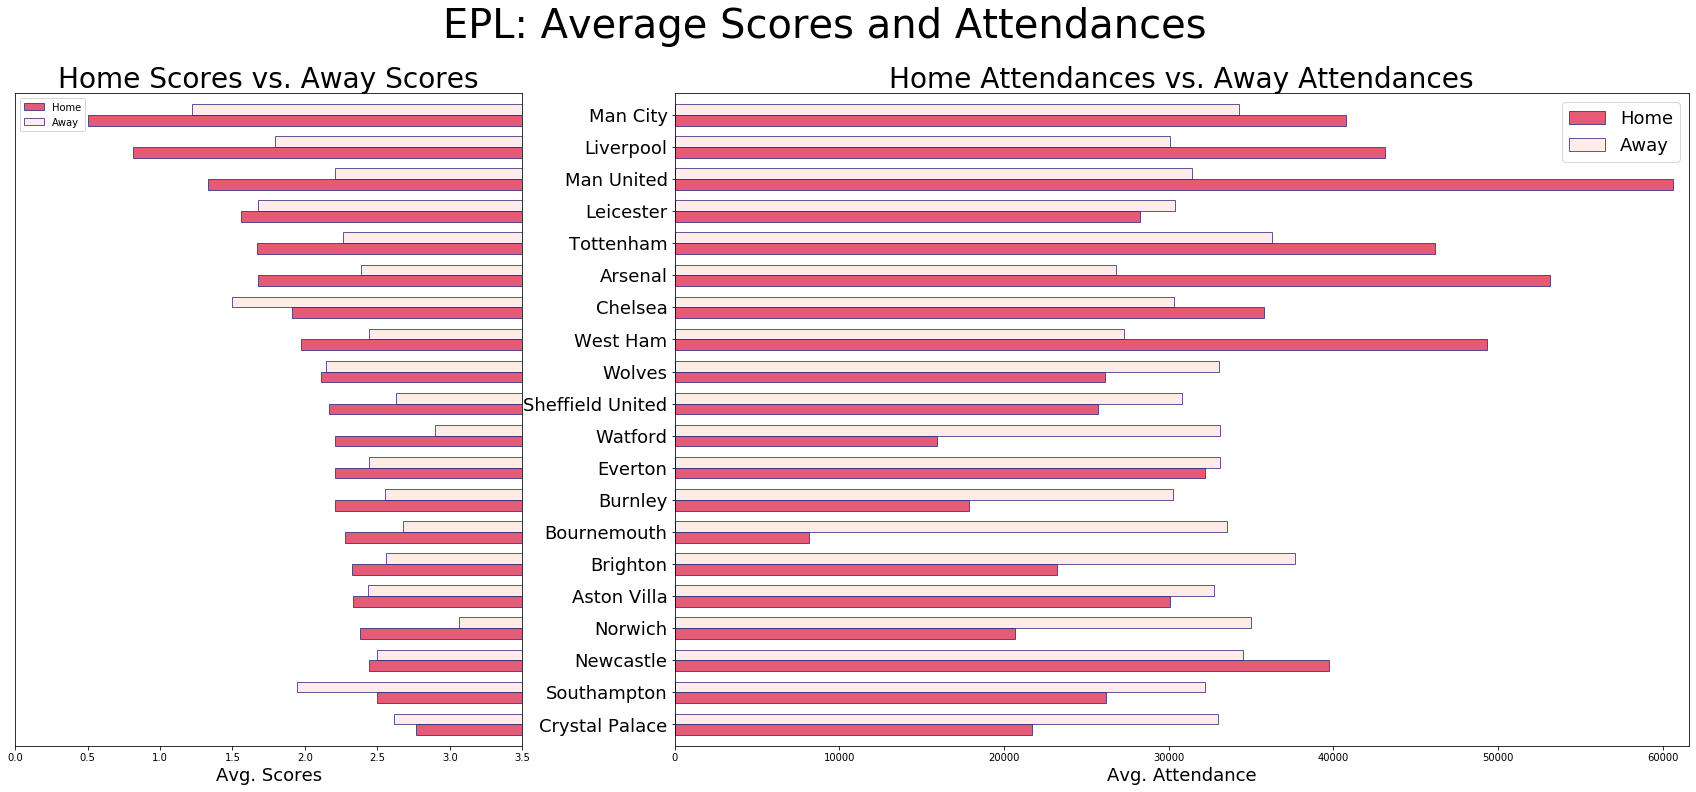

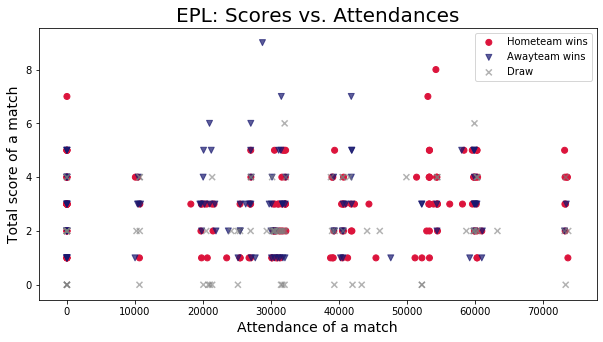

In [9]:
# Bar plot for each team of average scores and attendances
Home_Away_Avg_bar_chart(epl_df, "EPL")

# Scatter plot for all matches of match total scores and attendances
Att_Score_scatter(epl_df, "EPL")

* BUN (Bundesliga League)

In [10]:
# Load BUN data and fill na as 0
bun_all_data_df = pd.read_csv(bun_att_data)
bun_df = Summary(bun_all_data_df[cols], "BUN")
bun_df.describe()

The number of matches of BUN teams until 2020-06-27 is 304
The number of matches of BUN teams after COVID-19 is 82


,HomeScore,AwayScore,Attendance
count,304.000000,304.000000,304.000000
mean,1.661184,1.546053,29825.601974
std,1.400262,1.361124,24142.352192
min,0.000000,0.000000,0.000000
25%,1.000000,0.750000,0.000000
50%,1.000000,1.000000,27062.500000
75%,2.000000,2.000000,49100.000000
max,8.000000,6.000000,81365.000000


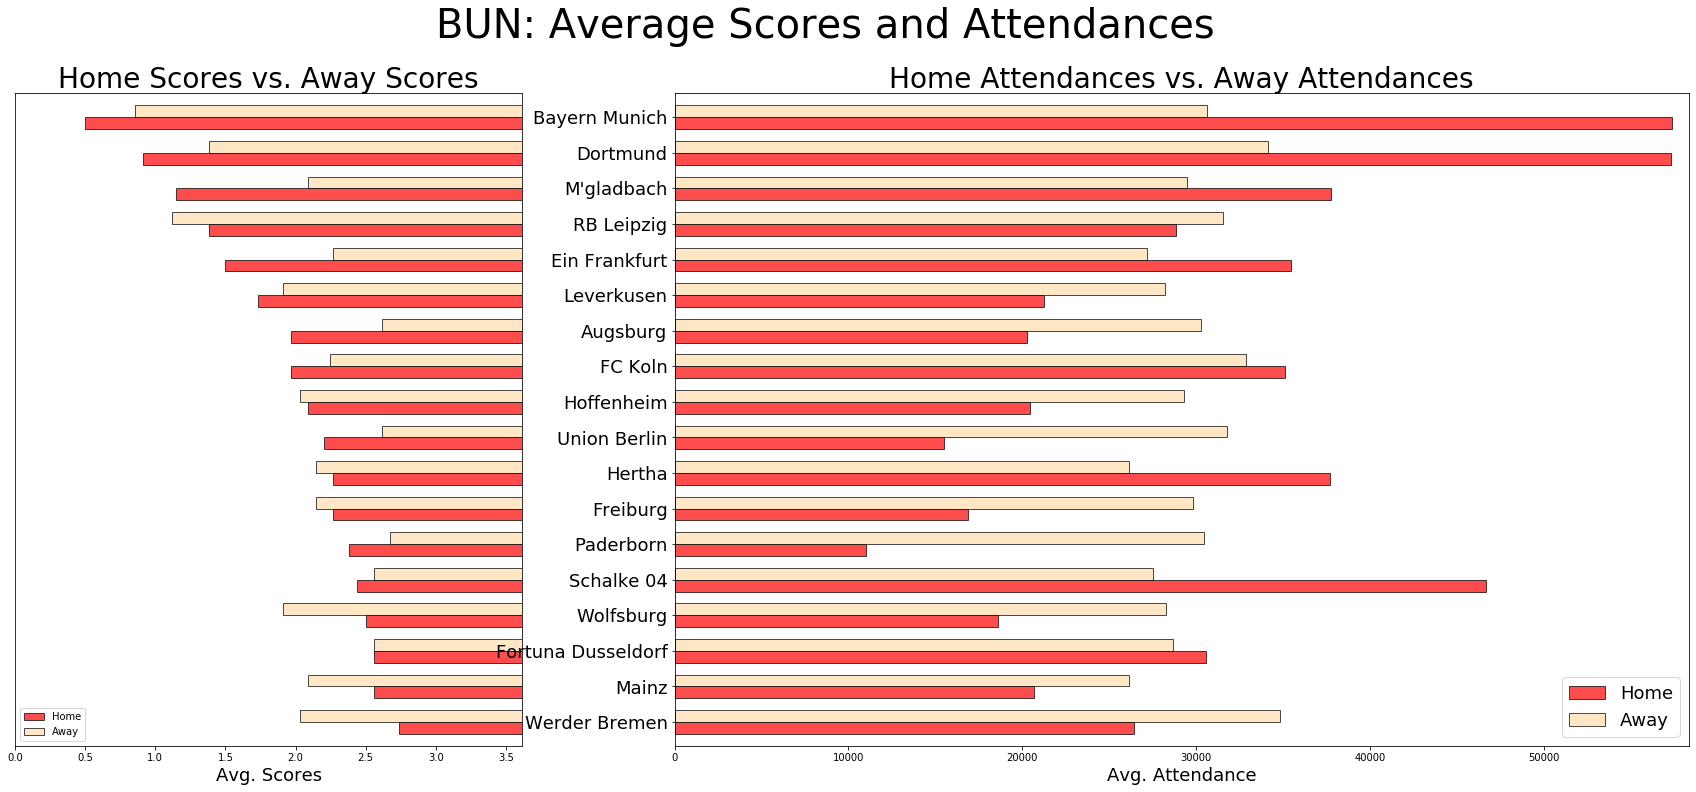

In [11]:
# Bar plot for each team of average scores and attendances
Home_Away_Avg_bar_chart(bun_df, "BUN")

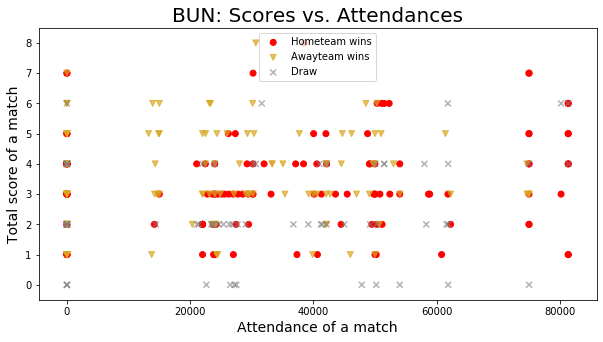

In [12]:
# Scatter plot for all matches of match total scores and attendances
Att_Score_scatter(bun_df, "BUN")

* LIG (La Liga League)

In [13]:
# Load LIG data and fill na as 0
lig_all_data_df = pd.read_csv(lig_att_data)
lig_df = Summary(lig_all_data_df[cols], "LIG")
lig_df.describe()

The number of matches of LIG teams until 2020-07-11 is 353
The number of matches of LIG teams after COVID-19 is 90


,HomeScore,AwayScore,Attendance
count,353.000000,353.000000,353.000000
mean,1.422096,1.025496,21613.399433
std,1.189571,1.009571,21250.311144
min,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000
50%,1.000000,1.000000,16295.000000
75%,2.000000,2.000000,34612.000000
max,6.000000,5.000000,93426.000000


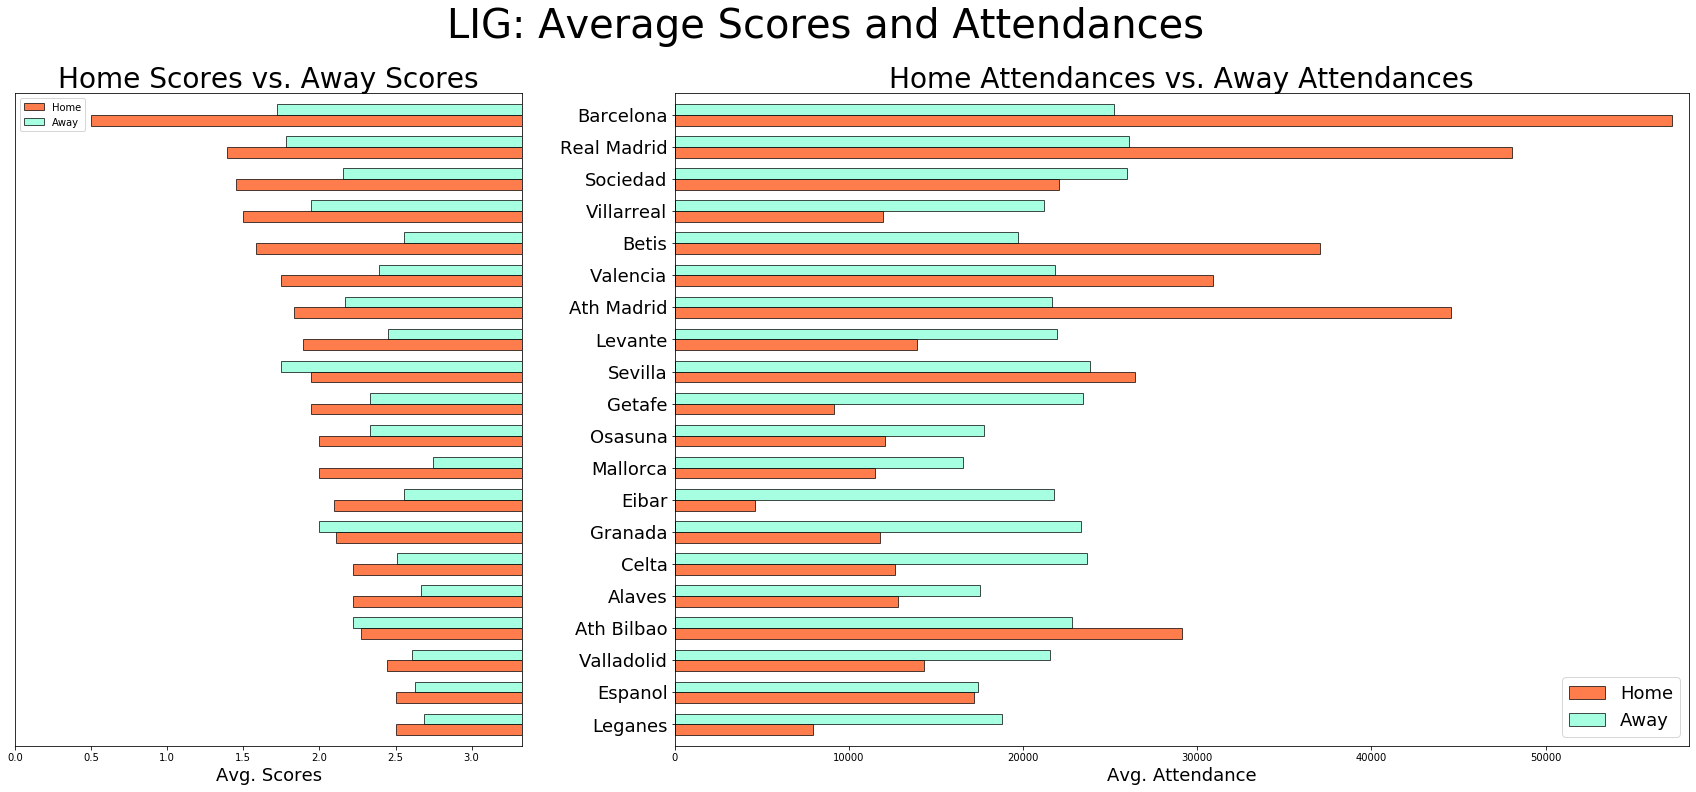

In [14]:
# Bar plot for each team of average scores and attendances
Home_Away_Avg_bar_chart(lig_df, "LIG")

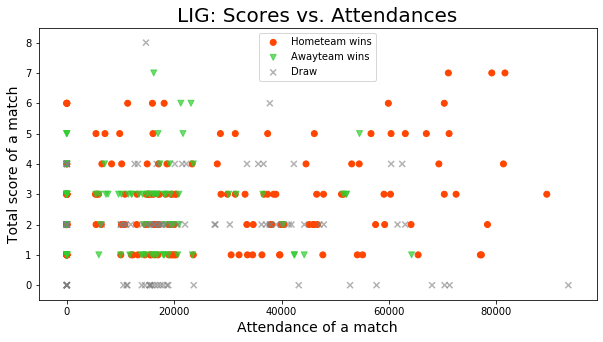

In [15]:
# Scatter plot for all matches of match total scores and attendances
Att_Score_scatter(lig_df, "LIG")

In [16]:
# Load SER data and fill na as 0
ser_all_data_df = pd.read_csv(ser_att_data)
ser_df = Summary(ser_all_data_df[cols], "SER")
ser_df.describe()

The number of matches of SER teams until 2019-11-10 is 117
The number of matches of SER teams after COVID-19 is 64


,HomeScore,AwayScore,Attendance
count,117.00000,117.000000,117.000000
mean,1.74359,1.478632,12165.205128
std,1.33361,1.178824,17299.008479
min,0.00000,0.000000,0.000000
25%,1.00000,1.000000,0.000000
50%,2.00000,1.000000,0.000000
75%,2.00000,2.000000,20771.000000
max,6.00000,7.000000,75923.000000


* SER (Serie A League)

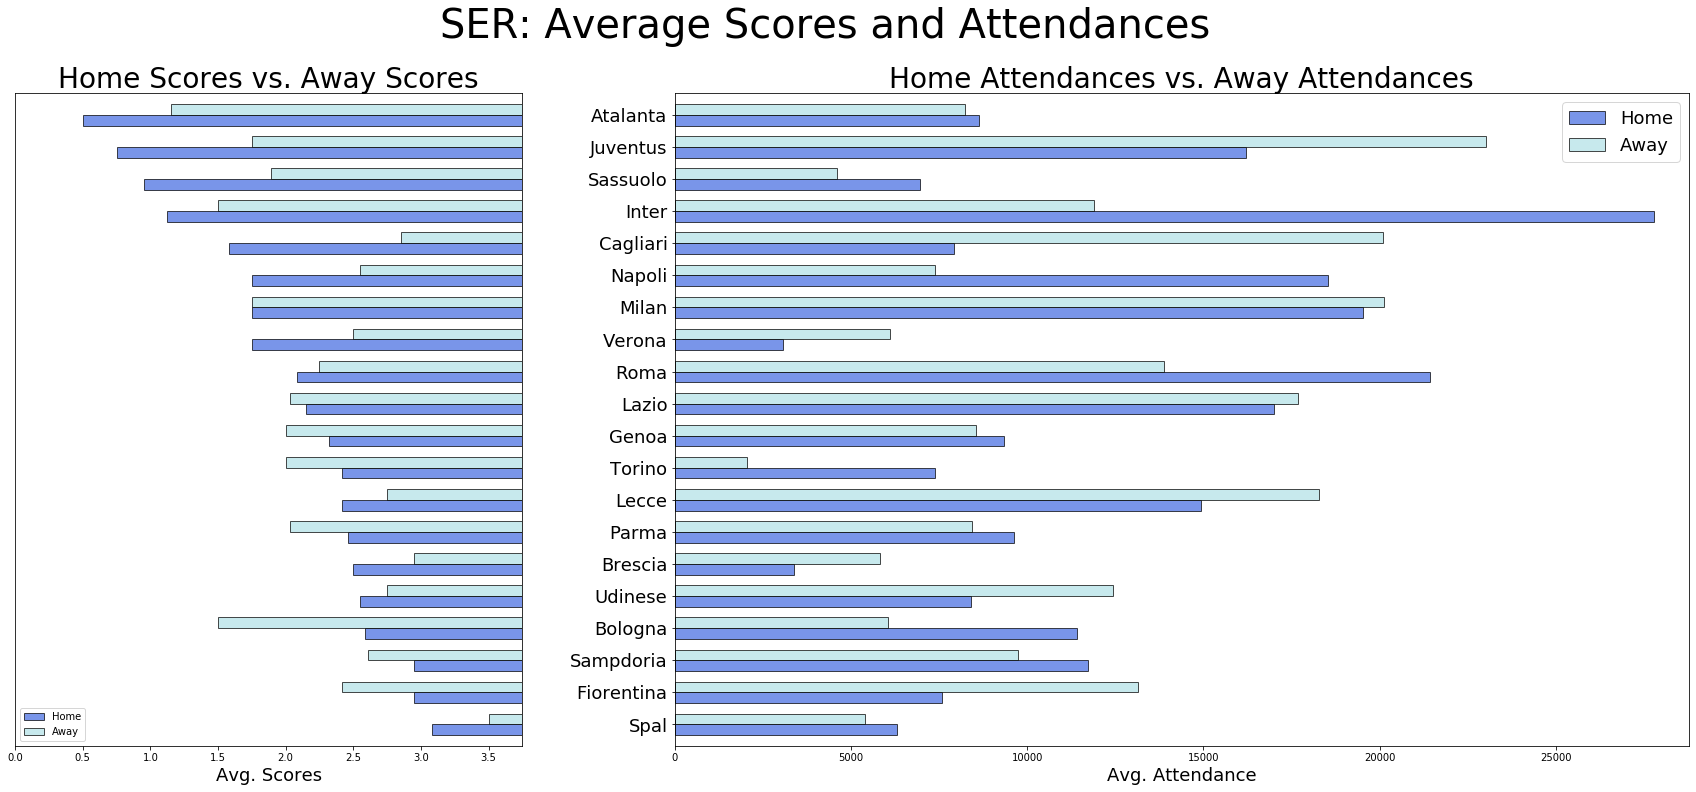

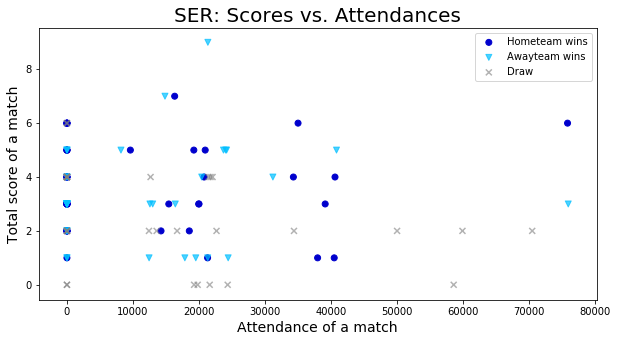

In [17]:
# Bar plot for each team of average scores and attendances
Home_Away_Avg_bar_chart(ser_df, "SER")
# Scatter plot for all matches of match total scores and attendances
Att_Score_scatter(ser_df, "SER")

In [18]:
# Combine four datasets to create the dataset for all matches
all_df = epl_df.append(bun_df, ignore_index=True)
all_df = all_df.append(lig_df, ignore_index=True)
all_df = all_df.append(ser_df, ignore_index=True)
all_df = Summary(all_df, "All")
all_df.describe()

The number of matches of All teams until 2020-07-13 is 1116
The number of matches of All teams after COVID-19 is 298


,HomeScore,AwayScore,Attendance
count,1116.000000,1116.000000,1116.000000
mean,1.553763,1.272401,26124.422939
std,1.285230,1.210266,22595.363563
min,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000
50%,1.000000,1.000000,23223.500000
75%,2.000000,2.000000,41234.250000
max,8.000000,9.000000,93426.000000


The r-sqared value of Hometeam wins is 0.01631403557313635
The r-sqared value of Awayteam wins is 0.006438427233286524


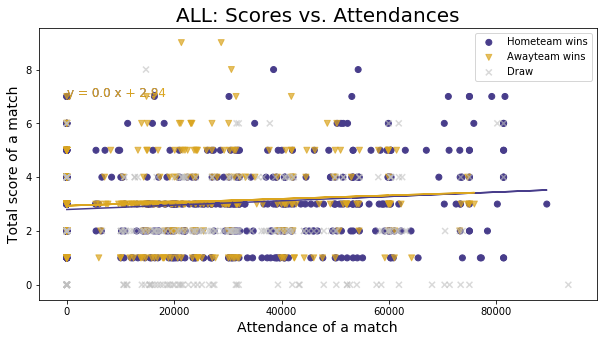

In [19]:
# Scatter plot for all matches of match total scores and attendances
Att_Score_scatter(all_df, "ALL")

## The teams of top attendances

In [20]:
att_top_teams = ["Man United", "Arsenal",      # EPL
           "Bayern Munich", "Dortmund",  # BUN,
           "Barcelona", "Real Madrid",   # LIG
           "Inter", "Roma"] # SER

att_top_df = pd.DataFrame()
for team in att_top_teams:
    att_top_df = att_top_df.append(all_df.loc[all_df["HomeTeam"]==team,:], ignore_index=True)

In [21]:
Summary(att_top_df, "popular").head()

The number of matches of popular teams until 2020-07-08 is 118
The number of matches of popular teams after COVID-19 is 31


,Date,HomeTeam,HomeTeam ID,HomeScore,AwayTeam,AwayTeam ID,AwayScore,Result,Attendance
0,2019-08-11,Man United,EPL11,4,Chelsea,EPL5,0,H,73620.0
1,2019-08-24,Man United,EPL11,1,Crystal Palace,EPL6,2,A,73454.0
2,2019-09-14,Man United,EPL11,1,Leicester,EPL8,0,H,73689.0
3,2019-09-30,Man United,EPL11,1,Arsenal,EPL0,1,D,73201.0
4,2019-10-20,Man United,EPL11,1,Liverpool,EPL9,1,D,73737.0


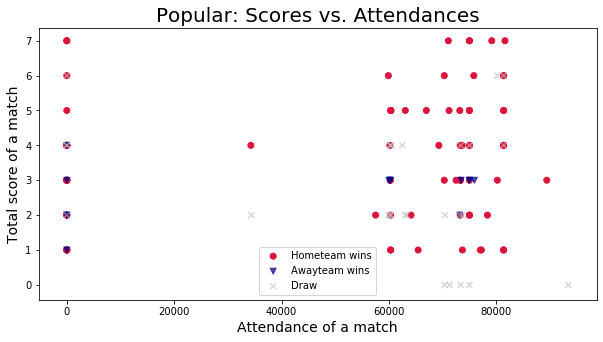

In [22]:
# Scatter plot for all matches of most popular teams total scores and attendances
Att_Score_scatter(att_top_df, "Popular")

## Top two teams for each league

In [40]:
scr_top_teams = ["Man City", "Liverpool",      # EPL
           "Bayern Munich", "Dortmund",  # BUN,
           "Barcelona", "Real Madrid",   # LIG
           "Atalanta", "Juventus"] # SER

scr_top_df = pd.DataFrame()
for team in att_top_teams:
    scr_top_df = scr_top_df.append(all_df.loc[all_df["HomeTeam"]==team,:], ignore_index=True)

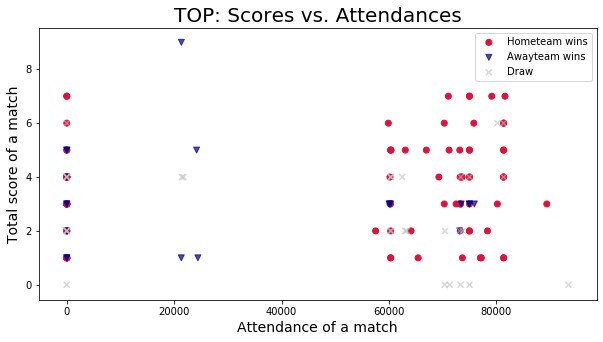

In [41]:
# Scatter plot for all matches of top score teams total scores and attendances
Att_Score_scatter(scr_top_df, "TOP")